# Table of Contents
* [1. Abstract](#1.-Abstract)
* [2. Introduction](#2.-Introduction)
	* [2.1 Checklist](#2.1-Checklist)
* [3. Experimental and computational details](#3.-Experimental-and-computational-details)
	* [3.1 Parameters](#3.1-Parameters)
	* [3.2 Initialize analysis framework](#3.2-Initialize-analysis-framework)
* [4. Experimental analysis](#4.-Experimental-analysis)
	* [4.1 Import experimental spectra](#4.1-Import-experimental-spectra)
	* [4.2 Resonance peak wavelength determination](#4.2-Resonance-peak-wavelength-determination)


The influence of shell structure on plasmonic resonances in core-shell metal-polymer nanoparticles 
=================================

# 1. Abstract

Plasmonic nanoparticles can be encapsulated in polymer shells with the capability for externally triggered swelling and collapse behaviors. This behavior can cause a shift in the LSPR peak wavelength due to changes in the scattering contribution and the NP near-field refractive index. It has been predicted that the increase in refractive index due to collapse will influence the resonance more than the change in scattering, resulting in a net red shift of the resonance peak position. Here we demonstrate this rule experimentally, while also showing that the structure and thickness of the shell play critical roles in the magnitude of the peak wavelength shift. 

# 2. Introduction

## 2.1 Checklist

- Determine peak position of spectra.
- Determine the near-field refractive index (NFRI) from a homogeneous medium fit (no shell).
  - Use the NFRI to determine the polymer grafting density.

# 3. Experimental and computational details

## 3.1 Parameters

- Synthesis protocols and structural analysis available in previous works
- Spherical cores and shells
- Core diameters $d_{\text{core}}=$ ? nm
- Shell diameters $d_{\text{shell}}=$ ?0 nm
- Au cores, with refractive index (RI) $n_{\text{Au}}$ from J&C 1972
- Relevant LSPR wavelengths $\lambda=$ 350-750 nm

## 3.2 Initialize analysis framework

- Mie theory calculations

In [1]:
%run "header.py"

Loading import modules ...
Loading analysis codes ... 
  ... refractive index functions loaded:
       Au, Ag, SiO2, ITO, ZnO, H2O, 
       ethanol, CS2, benzene, toluene, 
       chloroform, methanol, butanol, 
       propanol
  ... Mie functions loaded
  ... local Mie functions loaded
Ready player one.


In [2]:
%run "header_parallel.py"

Initializing cluster ...
   Client variable 'kernels'
   Cluster Direct View variable 'cluster'
   Variable 'nKernels' = 7
importing mie on engine(s)
importing mie_local on engine(s)


# 4. Experimental analysis

## 4.1 Import experimental spectra

In [191]:
print("Import and organize data")
print("========================")
folderName = 'data_20160905'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
spectraNames = []
spectraTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 0
    if (fileName == 'Au-linPNIPAM-long-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-medium-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-short-hydr-radius.dat'): 
        headerLines = 3
    elif (fileName == 'Au-linPNIPAM-long.dat'
          or fileName == 'Au-linPNIPAM-medium.dat'
          or fileName == 'Au-linPNIPAM-short.dat'): 
        headerLines = 2
        columnNames = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', dtype=str, comments='\\', skip_header=0, max_rows=1)[1:-1]
        spectraNames.append(columnNames.tolist())
        temps = []
        for name in columnNames:
            temps.append(float(name[-5:-3]))
        spectraTemps.append(temps)
        #print(columnNames)
    else: headerLines = 2
    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    return tempData
data = list(map(importData,fileNames))

# Last column indicates sample shell thickness:
# 0 = long (thick)
# 1 = medium
# 2 = short (thin)
print("Oganizing data ...")
dataList = []
for i in range(3):
    dlsData = data[2*i]
    spectraData0 = data[2*i+1]
    temps = spectraTemps[i]
    temps[0] = temps[0] + 1
    rh = interpolate.interp1d(dlsData[:,0], dlsData[:,1], kind="cubic")
    hydroRs = list(map(rh, temps))
    temps[0] = temps[0] - 1
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), i ]
            dataList.append(dataPoint)
dataArray = np.asarray(dataList)
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 0 = thick shell, 1 = medium, 2 = thin")

# Au cores only
spectrumCore = data[-1]
print("  * core alone sorted separately")

print("Done.")

Import and organize data
Importing data in folder data_20160905 ...
  * Au-linPNIPAM-long-hydr-radius.dat
  * Au-linPNIPAM-long.dat
  * Au-linPNIPAM-medium-hydr-radius.dat
  * Au-linPNIPAM-medium.dat
  * Au-linPNIPAM-short-hydr-radius.dat
  * Au-linPNIPAM-short.dat
  * AW5.txt
Oganizing data ...
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 0 = thick shell, 1 = medium, 2 = thin
  * core alone sorted separately
Done.


Sample spectrum
Exported to:
 graphics_sample-spectrum_20160905.svg


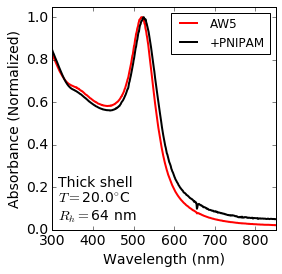

In [192]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Input data
    sampleNum = 0
    temp = spectraTemps[sampleNum][1]
    wlMin, wlMax = 300, 850
    
    sortByShell = dataArray[:,-1] == sampleNum
    plotArray = dataArray[sortByShell]
    sortByTemp = plotArray[:,-3] == temp
    plotArray = plotArray[sortByTemp]
    wlRange = plotArray[:,0] >= wlMin
    plotArray = plotArray[wlRange]
    wlRange = plotArray[:,0] <= wlMax
    plotArray = plotArray[wlRange]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.amax(y)
    xCore, yCore = spectrumCore[100:,0], spectrumCore[100:,1]
    yCore = yCore*np.amax(y)/np.amax(yCore)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)-np.amax(y)*.05, np.amax(y)*1.05]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(xCore, yCore, color='red', linewidth=2, label="AW5")
    pylab.plot(x, y, color='black', linewidth=2, label="+PNIPAM")
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (Normalized)")
    figText = (['Thick','Med.','Thin'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(temp)+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(plotArray[0][-2]))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"sample-spectrum_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Sample spectrum
Exported to:
 graphics_sample-spectrum_20160905.svg


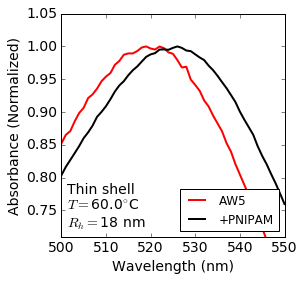

In [193]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Input data
    sampleNum = 2
    temp = spectraTemps[sampleNum][-1]
    wlMin, wlMax = 500, 550
    
    sortByShell = dataArray[:,-1] == sampleNum
    plotArray = dataArray[sortByShell]
    sortByTemp = plotArray[:,-3] == temp
    plotArray = plotArray[sortByTemp]
    wlRange = plotArray[:,0] >= wlMin
    plotArray = plotArray[wlRange]
    wlRange = plotArray[:,0] <= wlMax
    plotArray = plotArray[wlRange]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.amax(y)
    xCore, yCore = spectrumCore[100:,0], spectrumCore[100:,1]
    yCore = yCore*np.amax(y)/np.amax(yCore)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)-np.amax(y)*.05, np.amax(y)*1.05]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.plot(xCore, yCore, color='red', linewidth=2, label="AW5")
    pylab.plot(x, y, color='black', linewidth=2, label="+PNIPAM")
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (Normalized)")
    figText = (['Thick','Med.','Thin'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(temp)+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(plotArray[0][-2]))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"sample-spectrum_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


## 4.2 Resonance peak wavelength determination

In [201]:
print("LSPR analysis")
print("=============")
print("Peak detection")
threshold = 0.25
wlMinnm, wlMaxnm = 400, 600

# Core only
wlPeakCorenm = 0
wlRange = spectrumCore[:,0] >= wlMinnm
dataSubArray = spectrumCore[wlRange]
wlRange = spectrumCore[:,0] <= wlMaxnm
dataSubArray = spectrumCore[wlRange]
if dataSubArray.size > 0:
    x, y = dataSubArray[:,0], dataSubArray[:,1]
    base = peakutils.baseline(y,2)
    yCorr = y - base
    indexes = peakutils.indexes(y, thres=threshold, min_dist=10)
    indexesCorr = peakutils.indexes(yCorr, thres=threshold, min_dist=10)
    if indexes.size > 0: 
        if indexes.size > 1: indexes = [indexes[-1]]
        wlPeaknm = peakutils.interpolate(x, y, ind=indexes)
        wlPeakCorenm = wlPeaknm[0]
        print("Bare core LSPR peak at", format(wlPeakCorenm,'.1f'), " nm")

# Shell
lsprPeakList = []
for sampleNum in range(3):
    for tempC in spectraTemps[sampleNum]:
        sortByShell = dataArray[:,-1] == sampleNum
        dataSubArray = dataArray[sortByShell]
        sortByTemp = dataSubArray[:,-3] == tempC
        dataSubArray = dataSubArray[sortByTemp]
        wlRange = dataSubArray[:,0] >= wlMinnm
        dataSubArray = dataSubArray[wlRange]
        wlRange = dataSubArray[:,0] <= wlMaxnm
        dataSubArray = dataSubArray[wlRange]
        Rh = dataSubArray[0][-2]
        if dataSubArray.size > 0:
            x, y = dataSubArray[:,0], dataSubArray[:,1]
            base = peakutils.baseline(y,2)
            yCorr = y - base
            indexes = peakutils.indexes(y, thres=threshold, min_dist=10)
            indexesCorr = peakutils.indexes(yCorr, thres=threshold, min_dist=10)
            if indexes.size > 0: 
                if indexes.size > 1: indexes = [indexes[-1]]
                wlPeaknm = peakutils.interpolate(x, y, ind=indexes)
                lsprPeakList.append([wlPeaknm[0], tempC, Rh, sampleNum])
lsprPeakArray = np.asarray(lsprPeakList)
print("Shell peaks")
print("  * format: [ wl-nm, temp-C, Rh-nm, sample-# ]")
print("  * min LSPR peak at",format(np.amin(lsprPeakArray[:,0]),'.1f'),"nm")
print("  * max LSPR peak at",format(np.amax(lsprPeakArray[:,0]),'.1f'),"nm")

LSPR analysis
Peak detection
Bare core LSPR peak at 519.7  nm
Shell peaks
  * format: [ wl-nm, temp-C, Rh-nm, sample-# ]
  * min LSPR peak at 523.4 nm
  * max LSPR peak at 526.3 nm


LSPR peak wavelength vs hydrodynamic radius
Exported to:
 graphics_wl-LSPR-vs-Rh_20160905.svg


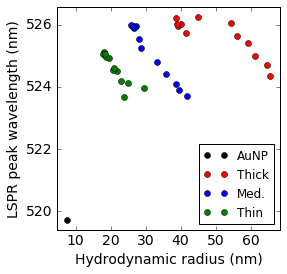

In [202]:
print('LSPR peak wavelength vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:3:2]
    x, y = plotArray[:,1], plotArray[:,0]
    x0, y0 = [7.5], [wlPeakCorenm]
    xLimits = [np.amin(x), np.amax(x)]
    xLimits[0] = min([xLimits[0],x0[0]])
    yLimits = [np.amin(y), np.amax(y)]
    yLimits[0] = min([yLimits[0],y0[0]])
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x0, y0, 'o', color='black', label="AuNP")
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Hydrodynamic radius (nm)")
    pylab.ylabel("LSPR peak wavelength (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-Rh_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


LSPR peak wavelength vs temperature
Exported to:
 graphics_wl-LSPR-vs-temp_20160905.svg


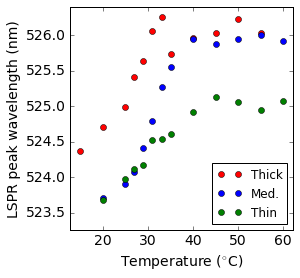

In [199]:
print('LSPR peak wavelength vs temperature')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,0:2]
    x, y = plotArray[:,1], plotArray[:,0]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("LSPR peak wavelength (nm)")
    pylab.legend(loc='lower right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"wl-LSPR-vs-temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


Temperature vs hydrodynamic radius
Exported to:
 graphics_Rh-vs-Temp_20160905.svg


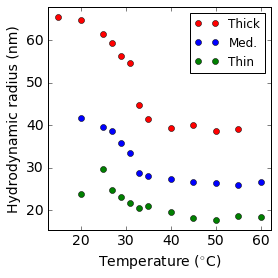

In [196]:
print('Temperature vs hydrodynamic radius')
print('===============')
def plotAndSave ():   
    ## Input data
    plotArray = lsprPeakArray[:,1:3]
    x, y = plotArray[:,0], plotArray[:,1]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    x1, y1 = x[:len(spectraTemps[0])], y[:len(spectraTemps[0])]
    x2, y2 = x[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])], y[len(spectraTemps[0])+1:len(spectraTemps[0])+len(spectraTemps[1])]
    x3, y3 = x[len(spectraTemps[0])+len(spectraTemps[1])+1:], y[len(spectraTemps[0])+len(spectraTemps[1])+1:]
    
    ## Specific format options
    pylab.plot(x1, y1, 'o', color='red', label="Thick")
    pylab.plot(x2, y2, 'o', color='blue', label="Med.")
    pylab.plot(x3, y3, 'o', color='green', label="Thin")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Hydrodynamic radius (nm)")
    pylab.legend(loc='upper right', fontsize=12)
    
    ## General format options
    aspectRatio = dx/dy
    figWidthcm = 8.9
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0]-0.05*dx, xLimits[1]+0.05*dx)
    pylab.ylim(yLimits[0]-0.05*dy, yLimits[1]+0.05*dy)
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics_"+"Rh-vs-Temp_" + timestamp + exportFormat
    pylab.savefig(filename, transparent=True)
    print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 
